In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace

from src.TiffStack import *

In [2]:
def show_flow(flow):
    step = 25
    Y, X = np.mgrid[0:flow.shape[0]:step, 0:flow.shape[1]:step]
    U = flow[::step, ::step, 0]  # dx
    V = flow[::step, ::step, 1]  # dy

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.quiver(X, Y, U, V, scale=200, pivot='tail', color='blue')
    plt.title("Optical Flow Vector Field")
    plt.xlim(0, flow.shape[1])
    plt.ylim(flow.shape[0], 0)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()

def preprocess_frame(frame, **kwargs):
        """
        Preprocesses a single frame by applying Gaussian and median blurs,
        normalization, and dtype conversion — all optionally customizable.

        Args:
            frame (np.ndarray): Input frame to preprocess.
            **kwargs: Dictionary with optional preprocessing config keys:
                - gauss: dict with 'ksize' and 'sigmaX'
                - median: dict with 'ksize'
                - normalize: dict with 'alpha', 'beta', 'norm_type'
                - convert: dict with 'dtype'

        Returns:
            np.ndarray: Preprocessed frame.
        """
        # defaults
        gauss_cfg = kwargs.get('gauss', {'ksize': (5, 5), 'sigmaX': 1.5})
        laplace_cfg = kwargs.get('laplace', {'sigmaX': 1.5})
        median_cfg = kwargs.get('median', {'ksize': 5})
        norm_cfg = kwargs.get('normalize', {'alpha': 0, 'beta': 255, 'norm_type': cv2.NORM_MINMAX})

        # processing
        processed = gaussian_laplace(frame, laplace_cfg['sigma'])
        processed = cv2.GaussianBlur(processed, gauss_cfg['ksize'], gauss_cfg['sigmaX'])
        processed = cv2.medianBlur(processed, median_cfg['ksize'])
        processed = cv2.normalize(processed, None, norm_cfg['alpha'], norm_cfg['beta'], norm_cfg['norm_type'])
        processed = cv2.convertScaleAbs(processed)
        return processed


def optical_flow(df,
                 pyr_scale=0.5,
                 levels=3,
                 winsize=15,
                 iterations=3,
                 poly_n=5,
                 poly_sigma=1.2,
                 flags=0,
                 **kwargs):
        """
        Computes dense optical flow using Farneback method on a preprocessed channel.

        Args:
            channel_idx (int): Channel index from TIFF stack.
            pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags:
                Parameters for cv2.calcOpticalFlowFarneback.
            **kwargs:
                Passed to self._preprocess_frame for filtering (e.g., blur configs).

        Returns:
            np.ndarray: (N-1, H, W, 2) flow vectors between frames.
        """
        preprocessed = np.stack([preprocess_frame(f, **kwargs) for f in df])
        num_frames, h, w = preprocessed.shape
        flow = np.empty((num_frames - 1, h, w, 2), dtype=np.float32)

        for i in range(num_frames - 1):
            f1 = preprocessed[i]
            f2 = preprocessed[i + 1]
            flow[i] = cv2.calcOpticalFlowFarneback(f1, f2, None,
                                                pyr_scale, levels, winsize,
                                                iterations, poly_n, poly_sigma, flags)
        return flow

In [8]:
f_path = "example_images/20220929_MCF_Rab5a_WH_heterotypic_s1_SCALED.tif"
img = TiffStack(f_path)
df = img.isolate_channel(0)
df.shape
# flow1 = img.optical_flow(channel_idx=1)
# flow2 = img.optical_flow(channel_idx=2)

(96, 520, 2329)

In [35]:
# # Apply GaussianBlur to each frame in the stack
gldf = np.array([gaussian_laplace(frame, sigma=1.0) for frame in df.copy()])

# # Apply gaussian_laplace to each frame in the stack
# gbdf = np.array([cv2.GaussianBlur(frame, (5, 5), 0) for frame in df.copy()])

# Apply Laplacian from CV2 to each frame in the stack
# cvgbdf = np.array([cv2.Laplacian(frame, cv2.CV_64F, 1) for frame in df.copy()])

In [4]:
def show_image(image, title='Image'):
    """
    Displays an image using matplotlib.

    Args:
        image (np.ndarray): Image to display.
        title (str): Title of the window. Default is 'Image'.

    Returns:
        None: Just displays the image.
    """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
dfg = df.copy()
dfg.shape

(96, 520, 2329)

In [9]:
dfg = df.copy()
args = {
    'gauss' : {'ksize': (5, 5), 'sigmaX': 1.5},
    'laplace': {'sigma': 1.5},
    'median': {'ksize': 5},
    'normalize': {'alpha': 0, 'beta': 255, 'norm_type': cv2.NORM_MINMAX}
}

flow = optical_flow(dfg,
                    pyr_scale=0.5,
                    levels=3,
                    winsize=15,
                    iterations=3,
                    poly_n=5,
                    poly_sigma=1.2,
                    flags=0,
                    **args)


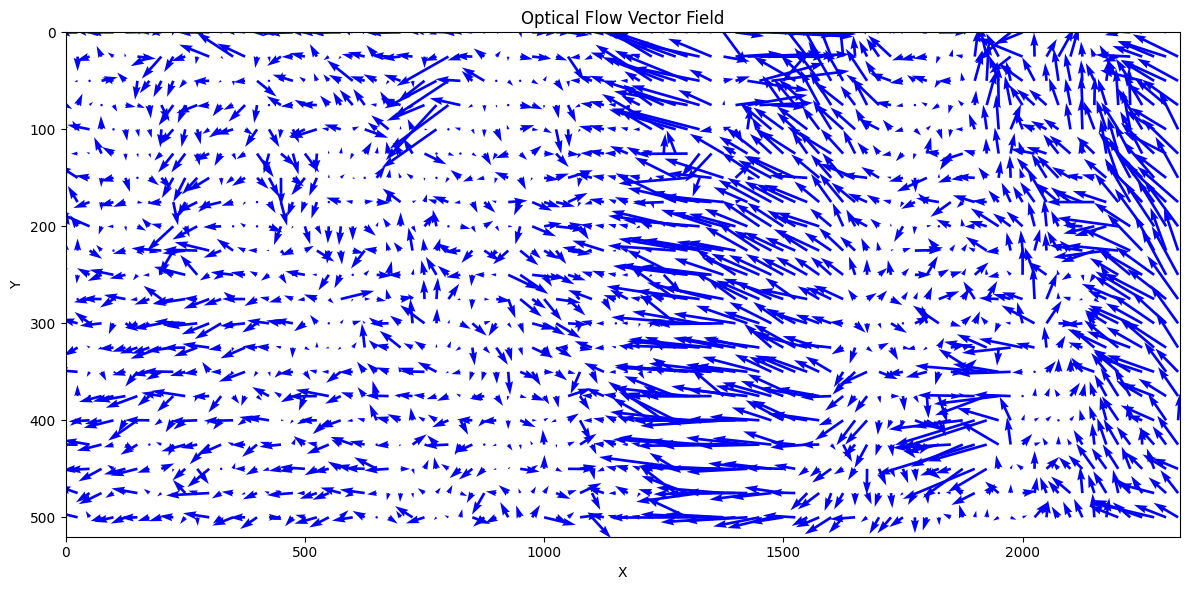

In [10]:
show_flow(flow[0])  # Show flow for the first frame pair

In [7]:
df = gldf
df.shape

(96, 520, 2329)

In [10]:
for frame in df:
    frame = preprocess_frame(frame)

In [14]:
flow = optical_flow(df)

In [16]:
flow.shape

(95, 520, 2329, 2)

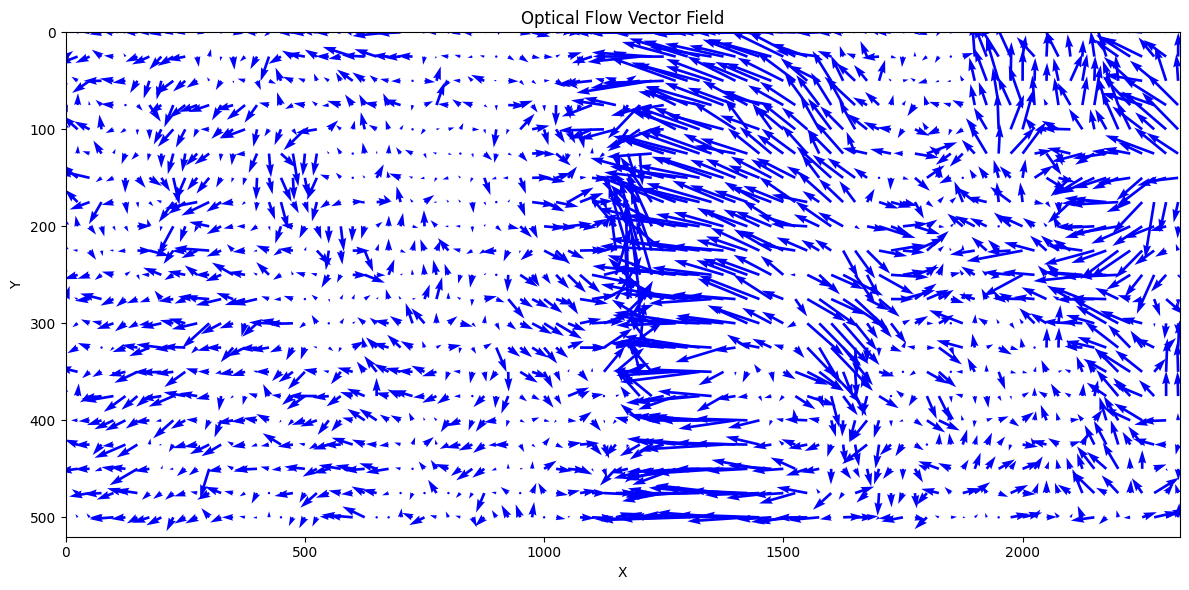

In [18]:
show_flow(flow[0])  # Show flow for the first frame pair

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace

def compute_flow_with_params(frame1, frame2, params):
    """
    Compute optical flow between two frames using specified parameters.
    Parameters:
        frame1: First frame (numpy array).
        frame2: Second frame (numpy array).
        params: Dictionary of parameters for cv2.calcOpticalFlowFarneback.
    Returns:
        flow: Optical flow field (numpy array).
    """
    return cv2.calcOpticalFlowFarneback(
        frame1, frame2,
        None,
        pyr_scale=params.get("pyr_scale", 0.5),
        levels=params.get("levels", 3),
        winsize=params.get("winsize", 15),
        iterations=params.get("iterations", 3),
        poly_n=params.get("poly_n", 5),
        poly_sigma=params.get("poly_sigma", 1.2),
        flags=params.get("flags", 0)
    )

def compute_smoothness(flow):
    """
    Compute the smoothness of the optical flow field.
    Parameters:
        flow: Optical flow field (numpy array).
    Returns:
        smoothness: Mean gradient magnitude of the flow field.
    """
    dx = np.gradient(flow[..., 0], axis=1)
    dy = np.gradient(flow[..., 1], axis=0)
    return np.mean(np.sqrt(dx**2 + dy**2))

def warp(img, flow):
    """
    Warp an image using the given flow vectors.
    Parmeters:
        img (np.ndarray): Single frame image.
        flow (np.ndarray): Optical flow for the frame, shape (H, W, 2).
    Returns:
        np.ndarray: Warped image.
    """
    h, w = img.shape
    flow_map = np.zeros_like(flow)
    flow_map[..., 0] = np.arange(w)
    flow_map[..., 1] = np.arange(h)[:, None]
    remap = flow_map + flow
    remap_x = remap[..., 0].astype(np.float32)
    remap_y = remap[..., 1].astype(np.float32)
    warped = cv2.remap(img, remap_x, remap_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return warped

def compute_temporal_consistency(frame1, frame2, flow12):
    """
    Compute temporal consistency between two frames using optical flow.
    Parameters:
        frame1: First frame (numpy array).
        frame2: Second frame (numpy array).
        flow12: Optical flow from frame1 to frame2 (numpy array).
    Returns:
        consistency: Mean squared error between frame1 and the warped frame2.
    """
    flow21 = compute_flow_with_params(frame2, frame1, params={
        "pyr_scale": 0.5,
        "levels": 3,
        "winsize": 15,
        "iterations": 3,
        "poly_n": 5,
        "poly_sigma": 1.2,
        "flags": 0
    })
    warped = warp(frame2, flow21)
    return np.mean((frame1 - warped) ** 2)

def compute_structure_preservation(frame1, warped_frame):
    """
    Compute structure preservation using Difference of Gaussian (DoG).
    Parameters:
        frame1: First frame (numpy array).
        warped_frame: Warped second frame (numpy array).
    Returns:
        structure: Mean absolute difference of Gaussian between the two frames.
    """
    dog1 = gaussian_laplace(frame1, sigma=1.0)
    dog2 = gaussian_laplace(warped_frame, sigma=1.0)
    return np.mean(np.abs(dog1 - dog2))

def evaluate(flows, frames):
    """
    Evaluate optical flow quality for a sequence of flows and frames using
    proxy metrics averaged over all frame pairs.
    Parameters:
        flows: List of optical flow fields (numpy arrays).
        frames: List of frames (numpy arrays).
    Returns:
        avg_score: Average score based on smoothness, temporal consistency, and structure preservation.
    """
    total_smoothness = 0
    total_consistency = 0
    total_structure = 0
    n = len(flows)

    for i in range(n):
        flow = flows[i]
        frame1 = frames[i]
        frame2 = frames[i + 1]

        dx = np.gradient(flow[..., 0], axis=1)
        dy = np.gradient(flow[..., 1], axis=0)
        smoothness = np.mean(np.sqrt(dx**2 + dy**2))

        warped = warp(frame2, flow)

        consistency = np.mean((frame1 - warped) ** 2)

        blur1_low = cv2.GaussianBlur(frame1, (0, 0), sigmaX=1.0)
        blur1_high = cv2.GaussianBlur(frame1, (0, 0), sigmaX=2.0)
        dog1 = blur1_low - blur1_high

        blur2_low = cv2.GaussianBlur(warped, (0, 0), sigmaX=1.0)
        blur2_high = cv2.GaussianBlur(warped, (0, 0), sigmaX=2.0)
        dog2 = blur2_low - blur2_high

        structure = np.mean(np.abs(dog1 - dog2))

        total_smoothness += smoothness
        total_consistency += consistency
        total_structure += structure

    avg_score = (total_smoothness / n) + 2 * (total_consistency / n) + (total_structure / n)
    return avg_score


In [ ]:
def evaluate(flows, frames):
    total_smoothness = 0
    total_consistency = 0
    total_structure = 0
    n = len(flows)

    for i in range(n):
        flow = flows[i]
        frame1 = frames[i]
        frame2 = frames[i + 1]

        dx = np.gradient(flow[..., 0], axis=1)
        dy = np.gradient(flow[..., 1], axis=0)
        smoothness = np.mean(np.sqrt(dx**2 + dy**2))

        warped = warp(frame2, flow)
        consistency = np.mean((frame1 - warped) ** 2)

        blur1_low = cv2.GaussianBlur(frame1, (0, 0), sigmaX=1.0)
        blur1_high = cv2.GaussianBlur(frame1, (0, 0), sigmaX=2.0)
        dog1 = blur1_low - blur1_high

        blur2_low = cv2.GaussianBlur(warped, (0, 0), sigmaX=1.0)
        blur2_high = cv2.GaussianBlur(warped, (0, 0), sigmaX=2.0)
        dog2 = blur2_low - blur2_high

        structure = np.mean(np.abs(dog1 - dog2))

        total_smoothness += smoothness
        total_consistency += consistency
        total_structure += structure

    avg_score = (total_smoothness / n) + 2 * (total_consistency / n) + (total_structure / n)
    return avg_score

In [5]:
import optuna

def objective(trial):
    pyr_scale = trial.suggest_float('pyr_scale', 0.3, 0.8)
    levels = trial.suggest_int('levels', 1, 5)
    winsize = trial.suggest_int('winsize', 5, 31, step=2)  # ensure odd
    iterations = trial.suggest_int('iterations', 1, 5)
    poly_n = trial.suggest_categorical('poly_n', [5, 7])
    poly_sigma = trial.suggest_float('poly_sigma', 1.1, 1.5)
    flags = 0

    gauss_sigmaX = trial.suggest_float('gauss_sigmaX', 0.5, 3.0)
    gauss_ksize = 5  # fixed odd number

    flows = img.optical_flow(
        channel_idx=0,
        pyr_scale=pyr_scale,
        levels=levels,
        winsize=winsize,
        iterations=iterations,
        poly_n=poly_n,
        poly_sigma=poly_sigma,
        flags=flags,
        gauss={'ksize': (gauss_ksize, gauss_ksize), 'sigmaX': gauss_sigmaX}
    )

    # raw frames for evaluation (dtype uint16, normalize before eval)
    raw_frames = img.isolate_channel(0)
    raw_frames = np.stack([cv2.normalize(f, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) for f in raw_frames])

    score = evaluate(flows, raw_frames)
    return score

/home/zsr/research/cell2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best score:", study.best_value)

[I 2025-05-23 18:35:31,052] A new study created in memory with name: no-name-a46999b0-0ba2-4edd-87c0-5f133cfaea23
[I 2025-05-23 18:35:54,862] Trial 0 finished with value: 226.23609820478404 and parameters: {'pyr_scale': 0.5454134012581089, 'levels': 4, 'winsize': 15, 'iterations': 3, 'poly_n': 5, 'poly_sigma': 1.2172463762989545, 'gauss_sigmaX': 0.8978016927712963}. Best is trial 0 with value: 226.23609820478404.
[I 2025-05-23 18:36:27,608] Trial 1 finished with value: 229.1426564013877 and parameters: {'pyr_scale': 0.6474893405431372, 'levels': 4, 'winsize': 5, 'iterations': 4, 'poly_n': 5, 'poly_sigma': 1.2556777616861723, 'gauss_sigmaX': 2.8219632326442188}. Best is trial 0 with value: 226.23609820478404.
[I 2025-05-23 18:36:45,752] Trial 2 finished with value: 232.49380915775993 and parameters: {'pyr_scale': 0.32504768156675934, 'levels': 1, 'winsize': 29, 'iterations': 3, 'poly_n': 5, 'poly_sigma': 1.4389096000816746, 'gauss_sigmaX': 1.3116431383775722}. Best is trial 0 with value

In [ ]:
kwarg = {'pyr_scale': 0.666983120881162, 'levels': 4, 'winsize': 7, 'iterations': 3, 'poly_n': 7, 'poly_sigma': 1.2162108213344163, 'gauss_sigmaX': 0.9410795922892445}